In [ ]:
!pip install -q mediapipe

In [ ]:
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task


In [ ]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np


def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

In [ ]:
from google.colab import files
uploaded = files.upload()  # Dosyalarını seç (ör: pose-1.jpg, pose-2.jpg, pose-3.jpg)
list(uploaded.keys())


Saving pose-3.jpg to pose-3 (1).jpg
Saving pose-2.jpg to pose-2 (1).jpg
Saving pose-1.jpg to pose-1 (1).jpg


['pose-3 (1).jpg', 'pose-2 (1).jpg', 'pose-1 (1).jpg']

pose-3 (1).jpg: both


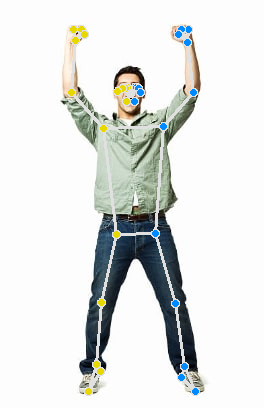

pose-2 (1).jpg: right


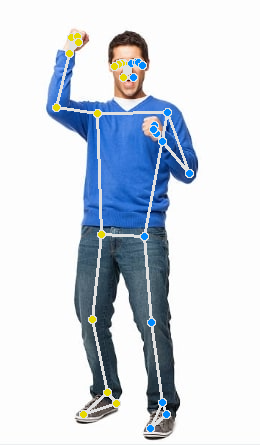

pose-1 (1).jpg: left


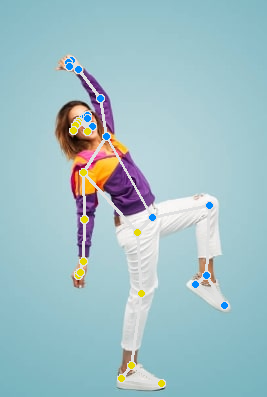

In [ ]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from google.colab.patches import cv2_imshow
import cv2

MP_IMAGE = mp.Image
BaseOptions = mp.tasks.BaseOptions
VisionRunningMode = mp.tasks.vision.RunningMode

# Pose landmark indeksleri
L_SHOULDER, R_SHOULDER = 11, 12
L_ELBOW,    R_ELBOW    = 13, 14
L_WRIST,    R_WRIST    = 15, 16

def _ok(p, thr=0.6):
    return getattr(p, "visibility", 1.0) >= thr

def is_arm_up(lmk, shoulder, elbow, wrist, margin=0.02, vis_thr=0.6):
    sh, el, wr = lmk[shoulder], lmk[elbow], lmk[wrist]
    if not (_ok(sh, vis_thr) and _ok(el, vis_thr) and _ok(wr, vis_thr)):
        return False
    # (0,0) sol-üst; y küçüldükçe yukarı
    return (wr.y < sh.y - margin) and (el.y < sh.y)

def classify_arm_state(landmarks):
    left_up  = is_arm_up(landmarks,  L_SHOULDER, L_ELBOW, L_WRIST)
    right_up = is_arm_up(landmarks, R_SHOULDER, R_ELBOW, R_WRIST)
    if left_up and right_up: return "both"
    if left_up:  return "left"
    if right_up: return "right"
    return "None"

# Pose Landmarker oluştur
options = vision.PoseLandmarkerOptions(
    base_options=BaseOptions(model_asset_path='pose_landmarker.task'),
    running_mode=VisionRunningMode.IMAGE,
    num_poses=1
)
landmarker = vision.PoseLandmarker.create_from_options(options)

# Yüklediğin her resim için çalıştır
for fname in uploaded.keys():
    image = MP_IMAGE.create_from_file(fname)
    result = landmarker.detect(image)

    if not result.pose_landmarks:
        print(f"{fname}: None (pose bulunamadı)")
        continue

    pred = classify_arm_state(result.pose_landmarks[0])
    print(f"{fname}: {pred}")

    # Görselleştir
    annotated = draw_landmarks_on_image(image.numpy_view(), result)
    annotated_bgr = cv2.cvtColor(annotated, cv2.COLOR_RGB2BGR)
    cv2_imshow(annotated_bgr)
